In [1]:
import os, sys
sys.path.append("C:/Users/piyalong/CrowdCounting-P2PNet/")

import argparse
import datetime
import random
import time
from pathlib import Path

import torch
import torchvision.transforms as transforms
import numpy as np

from PIL import Image
import cv2
from crowd_datasets import build_dataset
from engine import *
from models import build_model

from matplotlib import pyplot as plt
%matplotlib inline
torch.cuda.empty_cache() 

from torch.utils.data import DataLoader, DistributedSampler

from crowd_datasets import build_dataset
from engine import *
from models import build_model
from tensorboardX import SummaryWriter

import torch.nn.functional as F
from torch import nn

from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

from models.backbone import build_backbone
# from model.matcher import build_matcher_crowd

In [2]:
from skimage import io, transform

In [3]:
# print(model)

# Make folder to save model and tensorboard

In [4]:
date_folder='C:/Users/piyalong/TAMIDS_point/20230515_4/'

output_dir=os.path.join(date_folder,'out/')

tensorboard_dir=os.path.join(date_folder,'tensorboard/')
checkpoints_dir=os.path.join(date_folder,'ckpts/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

In [5]:
class Training_parameters():
    lr=1e-4
    lr_backbone=1e-5
    batch_size=1
    gpu_id=0
    backbone='vgg16_bn'
    output_dir=output_dir
    frozen_weights=None
    seed=42
    line=2
    # output_dir='output'
    point_loss_coef=0.0002
    row=2
    set_cost_class=1
    set_cost_point=0.05
    eos_coef=0.5
    lr_drop=3500
    dataset_file='SHHA'
    num_workers=0
    data_root='D:/20230426CDI/data/'
    tensorboard_dir=tensorboard_dir
    checkpoints_dir=checkpoints_dir
    eval_freq=5
    resume=''
    start_epoch=0
    epochs=3500
    clip_max_norm=0.1
    eval='store_true'
args=Training_parameters()

In [6]:
date_folder

'C:/Users/piyalong/TAMIDS_point/20230515_4/'

In [7]:
args.data_root

'D:/20230426CDI/data/'

# Build Model

In [8]:
class P2PNet(nn.Module):
    def __init__(self, backbone, row=2, line=2):
        super().__init__()
        self.backbone = backbone
        self.num_classes = 2
        # the number of all anchor points
        num_anchor_points = row * line

        self.regression = RegressionModel(num_features_in=256, num_anchor_points=num_anchor_points)
        self.classification = ClassificationModel(num_features_in=256, \
                                            num_classes=self.num_classes, \
                                            num_anchor_points=num_anchor_points)

        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=row, line=line)

        self.fpn = Decoder(256, 512, 512)

    def forward(self, samples: NestedTensor):
        # get the backbone features
        features = self.backbone(samples)
        # forward the feature pyramid
        features_fpn = self.fpn([features[1], features[2], features[3]])

        batch_size = features[0].shape[0]
        # run the regression and classification branch
        regression = self.regression(features_fpn[1]) * 100 # 8x
        classification = self.classification(features_fpn[1])
        anchor_points = self.anchor_points(samples).repeat(batch_size, 1, 1)
        # decode the points as prediction
        output_coord = regression.to(device) + anchor_points.to(device)
        output_class = classification
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out

In [9]:
from models.p2pnet import *

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = build_backbone(args)

model = P2PNet(backbone, args.row, args.line)

model.to(device)

P2PNet(
  (backbone): Backbone_VGG(
    (body1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
    )
    (body2): Sequential(
      (0): MaxPool2d(ke

# Custom Dataset

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(root_dir, filename)
                self.images.append(img_path)
                
                target = os.path.join(root_dir, filename[:-4]+'.txt')
                self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        assert idx <= len(self), 'index range error'
        img_path = self.images[idx]
        gt_path = self.targets[idx]
        
        image = io.imread(img_path)
        points = []
        with open(gt_path) as f_label:
            for line in f_label:
                x = float(line.strip().split(' ')[0])
                y = float(line.strip().split(' ')[1])
                points.append([x, y])
            
        sample = {'image': image, 'landmarks': np.array(points)}

        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    
datatransform = transforms.Compose([
                                   Rescale(256),
                                   # RandomCrop(1000),
                                   ToTensor()
                                           ])



In [13]:
dataset_train=CustomDataset('D:/20230426CDI/data/train/',datatransform)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

In [14]:
dataset_test=CustomDataset('D:/20230426CDI/data/test/',datatransform)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [15]:
len(data_loader_train)

90

In [16]:
len(dataset_train)

90

In [17]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    image_numpy = np.transpose(image, (1, 2, 0))
    image_numpy=image_numpy.numpy().copy() 
    plt.imshow(image_numpy)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='s', c='y')
    plt.pause(0.001)  # pause a bit so that plots are updated

# plt.figure()
# show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
#                landmarks)
# plt.show()

0 torch.Size([3, 256, 256]) torch.Size([9, 2])


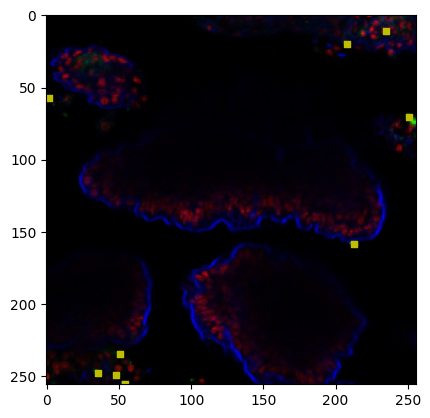

1 torch.Size([3, 256, 256]) torch.Size([11, 2])


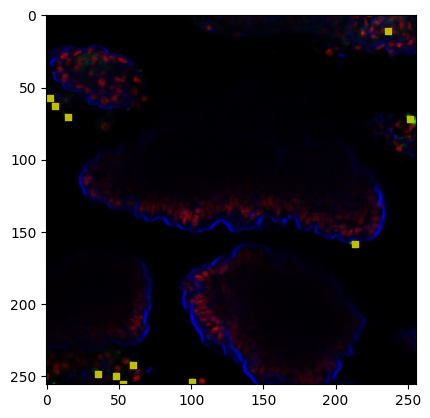

2 torch.Size([3, 256, 256]) torch.Size([12, 2])


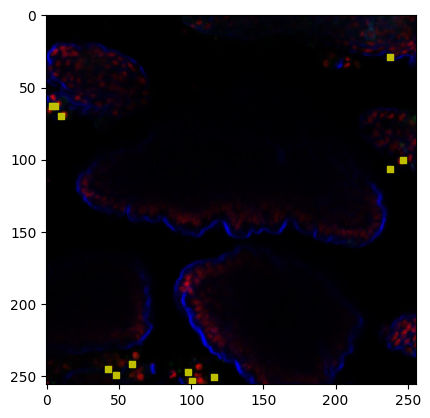

3 torch.Size([3, 256, 256]) torch.Size([14, 2])


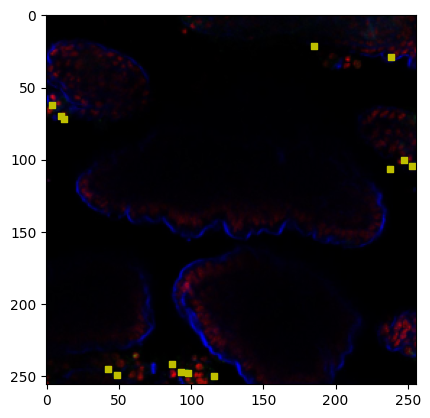

In [18]:
for i in range(len(dataset_test)):
    sample = dataset_test[i]

    print(i, sample['image'].size(), sample['landmarks'].size())
    show_landmarks(sample['image'],sample['landmarks'])   
    sample['landmarks']
    if i == 3:
        break

In [19]:
sample['landmarks']

tensor([[237.5000, 106.5000],
        [247.2500, 100.5000],
        [253.0000, 104.5000],
        [184.7500,  21.5000],
        [238.2500,  29.0000],
        [  3.5000,  62.2500],
        [  9.5000,  69.7500],
        [ 11.7500,  71.7500],
        [ 42.5000, 245.0000],
        [ 48.5000, 249.0000],
        [ 86.7500, 241.7500],
        [ 93.0000, 247.0000],
        [ 98.0000, 247.5000],
        [116.0000, 250.0000]], dtype=torch.float64)

0 torch.Size([1, 3, 256, 256]) torch.Size([1, 12, 2])
1 torch.Size([1, 3, 256, 256]) torch.Size([1, 7, 2])
2 torch.Size([1, 3, 256, 256]) torch.Size([1, 24, 2])
3 torch.Size([1, 3, 256, 256]) torch.Size([1, 14, 2])


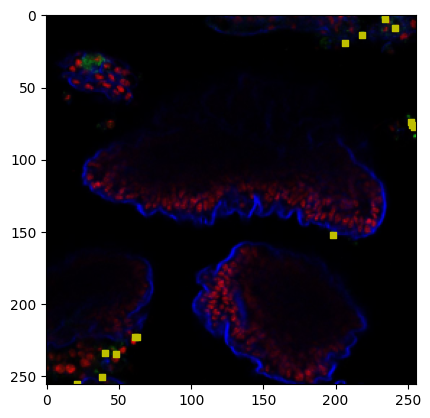

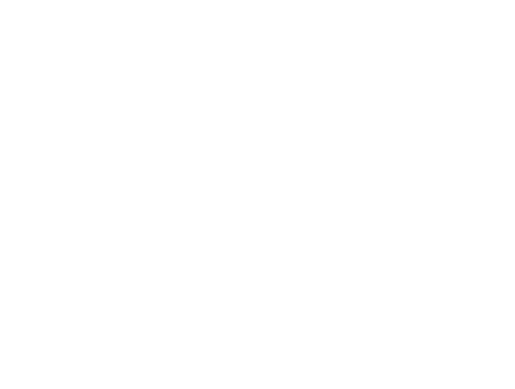

In [20]:
for i_batch, sample_batched in enumerate(data_loader_test):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        for i in range(sample_batched['image'].shape[0]):
            plt.figure()
            show_landmarks(sample_batched['image'][i],sample_batched['landmarks'][i])
            plt.axis('off')
            plt.ioff()
            plt.show()
        break

In [21]:
sample_batched['image'].shape[0]

1

In [22]:
range(1)

range(0, 1)

# rewrite loss function

In [23]:
from scipy.optimize import linear_sum_assignment
import numpy as np
from scipy.spatial.distance import cdist

In [24]:
class Loss_function():
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
        self.cost_matrixs = None
        
        
    def match(self,y_pred, y_true):
        self.cost_matrixs=[]
        indices=[]
        for predicted_points, gt_points in zip (y_pred, y_true):
            
            predicted_points= predicted_points.cpu().detach().numpy()

            gt_points = gt_points.cpu().detach().numpy()
            
            # print(predicted_points.shape, gt_points.shape)
            
            cost_matrix=cdist(predicted_points, gt_points, 'euclidean')
            self.cost_matrixs.append(cost_matrix)
            row_indices, col_indices = linear_sum_assignment(cost_matrix)

            indices.append([row_indices, col_indices])

        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
    
    def loss_labels(self, outputs, y_true, indices, num_points):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        # target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes_o=torch.ones([y_true.shape[1]]).long().to(device)
        target_classes = torch.full(src_logits.shape[:2], 0,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes)

        # print('target_classes_o: {} \n target_classes.shape: {} \n loss_ce:{} \n idx:  {} src_logits.shape {}'.format(target_classes_o,target_classes.shape,loss_ce,idx,src_logits.shape))

        return loss_ce 

    def _get_src_permutation_idx( self,indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def loss_points(self, outputs, targets, indices, num_points):

        assert 'pred_points' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_points = outputs['pred_points'][idx].float()
        target_points = torch.cat([t[i] for t, (_, i) in zip(targets, indices)], dim=0).float().to(device)

        loss_bbox = F.mse_loss(src_points, target_points, reduction='none')

        # print('src_points{} ,target_points {},loss_bbox.sum() {}, num_points{}'.format( src_points,target_points,loss_bbox.sum(), num_points))
        return loss_bbox.sum() / num_points

In [25]:
loss= Loss_function()

# Load model with weights

In [26]:
# PATH='C:/Users/piyalong/PointTracking/20230506/ckpts/best_mae.pth'
# PATH='C:/Users/piyalong/TAMIDS_Point/20230515_1/ckpts/best_mae.pth'
PATH='C:/Users/piyalong/CrowdCounting-P2PNet/weights/SHTechA.pth'


In [27]:
checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
# model.eval()

<All keys matched successfully>

# Evaluate on One Batch

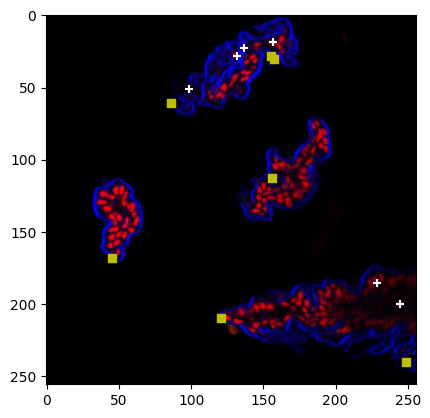

tensor([5.5000], device='cuda:0', grad_fn=<AddBackward0>)


In [28]:
sample = next(iter(data_loader_test))
outputs = model(sample['image'].float().to(device))
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]
outputs_points = outputs['pred_points'][0]

threshold = 0.45
# filter the predictions
points = outputs_points[outputs_scores > threshold].detach().cpu().numpy()
predict_cnt = int((outputs_scores > threshold).sum())
scores= outputs_scores[outputs_scores > threshold]

image_numpy = np.transpose(sample['image'][0], (1, 2, 0))
img_to_draw=image_numpy.numpy().copy() 

# draw the predictions
size = 40

plt.scatter(sample['landmarks'][0][:, 0], sample['landmarks'][0][:, 1], s=size, marker='s', c='y')

plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='w')

plt.imshow(img_to_draw)
plt.show()

y_true=sample['landmarks']
y_pred= outputs['pred_points']

num_points = y_true.shape[1]
num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

idx = loss.match(y_pred,y_true)

class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
losses = class_loss+coornidate_loss

print(class_loss+coornidate_loss)


In [29]:
points

array([[136.56808 ,  22.448292],
       [156.79071 ,  18.421164],
       [131.74742 ,  28.373232],
       [ 98.138145,  50.74121 ],
       [228.44351 , 185.25041 ],
       [244.5582  , 199.94608 ]], dtype=float32)

In [30]:

def evaluate(data_loader_test):

    for sample in data_loader_test:
        
        outputs = model(sample['image'].float().to(device))

        y_true=sample['landmarks']
        y_pred= outputs['pred_points']
        
        num_points = y_true.shape[1]
        num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

        idx = loss.match(y_pred,y_true)

        class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
        coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
        
        return class_loss,coornidate_loss
        


In [31]:
eval_loss = evaluate(data_loader_test)
eval_loss

(tensor(0.0395, device='cuda:0', grad_fn=<NllLoss2DBackward>),
 tensor([4.8303], device='cuda:0', grad_fn=<DivBackward0>))

In [32]:
losses

tensor([5.5000], device='cuda:0', grad_fn=<AddBackward0>)

In [33]:
args.epochs

3500

# Transfer Learning

In [34]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [35]:
# Adam is used by default
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001 )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose =True)

writer = SummaryWriter(args.tensorboard_dir)

loss= Loss_function()
loss_history=[]

for name, param in model.named_parameters():
    # print(name, param.requires_grad )
    if 'regression.output' in name:
        param.requires_grad=True
        print(param.requires_grad )


    elif 'classification.output' in name:
        param.requires_grad=True
        print(param.requires_grad )
        
    else:
        param.requires_grad=False

# iterate all training samples
for epoch in range(args.epochs):
    model.train()
    print(get_lr(optimizer))
    t1 = time.time()
    for sample in data_loader_train:
      
        outputs = model(sample['image'].float().to(device))

        y_true=sample['landmarks']
        y_pred= outputs['pred_points']
        
        num_points = y_true.shape[1]
        num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

        idx = loss.match(y_pred,y_true)

        class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
        coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
        losses = class_loss+coornidate_loss
        # backward
        optimizer.zero_grad()
        losses.backward()
        # coornidate_loss.backward()
        optimizer.step()
        
        # print('epoch:{},coornidate_loss: {} ,class_loss: {}'.format(epoch,coornidate_loss,class_loss))

        if writer is not None:
            writer.add_scalar('loss/coornidate_loss', coornidate_loss, epoch)
            writer.add_scalar('loss/class_loss',class_loss, epoch)

        checkpoint_latest_path = os.path.join(args.checkpoints_dir, 'latest.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_latest_path)
# evaluate and change learning rate and save best model
    model.eval()
    class_loss_eval,coornidate_loss_eval = evaluate(data_loader_test)
    loss_eval=class_loss_eval+coornidate_loss_eval
    loss_history.append(loss_eval.detach()) 
    print('epoch:{},coornidate_loss_eval: {} ,class_loss_eval: {}'.format(epoch,coornidate_loss_eval,class_loss_eval))

    if abs(np.min(loss_history[0].cpu().detach().numpy()) - loss_eval[0]) < 0.01:
        checkpoint_best_path = os.path.join(args.checkpoints_dir, 'best_mae.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_best_path)    

    if writer is not None:
        writer.add_scalar('metric/coornidate_loss_eval', coornidate_loss_eval, epoch)
        writer.add_scalar('metric/class_loss_eval',class_loss_eval, epoch)    
    scheduler.step(loss_eval)
    

epoch:2327,coornidate_loss_eval: tensor([4.3872], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.016589665785431862
1.0000000000000004e-08
epoch:2328,coornidate_loss_eval: tensor([6.2359], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.031211882829666138
1.0000000000000004e-08
epoch:2329,coornidate_loss_eval: tensor([3.1668], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.017307475209236145
1.0000000000000004e-08
epoch:2330,coornidate_loss_eval: tensor([3.6062], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.07715344429016113
1.0000000000000004e-08
epoch:2331,coornidate_loss_eval: tensor([1.6824], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.016022881492972374
1.0000000000000004e-08
epoch:2332,coornidate_loss_eval: tensor([2.4020], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.026947399601340294
1.0000000000000004e-08
epoch:2333,coornidate_loss_eval: tensor([3.8610], device='cuda:0', grad_fn=<DivBack

In [36]:
for name, param in model.named_parameters():
    # print(name, param.requires_grad )
    if 'regression.output' in name:
        param.requires_grad=True
        print(param.requires_grad )


    elif 'classification.output' in name:
        param.requires_grad=True
        print(param.requires_grad )
        
    else:
        param.requires_grad=False

True
True
True
True


In [37]:
for name, param in model.named_parameters():
    print(name, param.requires_grad )

backbone.body1.0.weight False
backbone.body1.0.bias False
backbone.body1.1.weight False
backbone.body1.1.bias False
backbone.body1.3.weight False
backbone.body1.3.bias False
backbone.body1.4.weight False
backbone.body1.4.bias False
backbone.body1.7.weight False
backbone.body1.7.bias False
backbone.body1.8.weight False
backbone.body1.8.bias False
backbone.body1.10.weight False
backbone.body1.10.bias False
backbone.body1.11.weight False
backbone.body1.11.bias False
backbone.body2.1.weight False
backbone.body2.1.bias False
backbone.body2.2.weight False
backbone.body2.2.bias False
backbone.body2.4.weight False
backbone.body2.4.bias False
backbone.body2.5.weight False
backbone.body2.5.bias False
backbone.body2.7.weight False
backbone.body2.7.bias False
backbone.body2.8.weight False
backbone.body2.8.bias False
backbone.body3.1.weight False
backbone.body3.1.bias False
backbone.body3.2.weight False
backbone.body3.2.bias False
backbone.body3.4.weight False
backbone.body3.4.bias False
backbone.b

In [38]:
get_lr(optimizer)

1.0000000000000004e-08